In [75]:
from __future__ import annotations

import os
from dataclasses import dataclass
from typing import Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
@dataclass
class Config:
    base_dir: str = "task4_output"
    input_name: str = "points.txt"

    # Параметры операций
    mul_k: float = 2.0
    add_b: float = 5.0
    gaussian_sigma: float = 2.0
    ma_window: int = 5

    # Для фильтрации по диапазону
    filter_lo: float = 0.3
    filter_hi: float = 1.2

    # Для демонстрации интерполяции
    inject_nans: bool = True
    nan_ratio: float = 0.08
    nan_seed: int = 123

    cmap: str = "viridis"

cfg = Config()

In [43]:
os.makedirs(cfg.base_dir, exist_ok=True)
out_file = os.path.join(cfg.base_dir, cfg.input_name)
print("Вход/выход папка:", cfg.base_dir)
print("Файл входных данных:", out_file)

Вход/выход папка: task4_output
Файл входных данных: task4_output/points.txt


0.1 Визуализация


In [42]:
def visualize_scalar_field(
    pts: np.ndarray,
    title: str = "Скалярное поле",
    cmap: str = "viridis",
    point_size: int = 4
) -> None:
    """
    Визуализация скалярного поля.

    Ожидаемый формат pts:
    pts[:, 0] — x
    pts[:, 1] — y
    pts[:, 2] — z
    pts[:, 3] — s (скалярное поле)
    """

    x = pts[:, 0]
    y = pts[:, 1]
    z = pts[:, 2]
    s = pts[:, 3]

    fig = plt.figure(figsize=(14, 10))

    # -----------------------------
    # 3D облако точек с раскраской
    # -----------------------------
    ax1 = fig.add_subplot(221, projection="3d")
    sc = ax1.scatter(
        x, y, z,
        c=s,
        cmap=cmap,
        s=point_size
    )
    ax1.set_title(f"{title}\n3D облако")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    plt.colorbar(sc, ax=ax1, shrink=0.6)

    # -----------------------------
    # График скалярного поля
    # -----------------------------
    ax2 = fig.add_subplot(222)
    ax2.plot(s)
    ax2.set_title("Скалярное поле")
    ax2.set_xlabel("Индекс точки")
    ax2.set_ylabel("s")
    ax2.grid(True)

    # -----------------------------
    # Гистограмма значений
    # -----------------------------
    ax3 = fig.add_subplot(223)
    ax3.hist(s[~np.isnan(s)], bins=50)
    ax3.set_title("Гистограмма скалярного поля")
    ax3.set_xlabel("s")
    ax3.set_ylabel("Количество")

    # -----------------------------
    # XY-проекция (наглядно)
    # -----------------------------
    ax4 = fig.add_subplot(224)
    sc2 = ax4.scatter(
        x, y,
        c=s,
        cmap=cmap,
        s=point_size
    )
    ax4.set_title("Проекция XY")
    ax4.set_xlabel("X")
    ax4.set_ylabel("Y")
    plt.colorbar(sc2, ax=ax4)

    plt.tight_layout()
    plt.show()

0.2 Генерация данных

In [18]:
def gen_two_gaussians(n: int = 6000, seed: int = 42) -> np.ndarray:
    """
    Два облака точек и поле s = exp(-dist_to_center1^2) + 0.7*exp(-dist_to_center2^2).
    """
    rng = np.random.default_rng(seed)
    n1 = n // 2
    n2 = n - n1

    c1 = np.array([ -0.6, 0.0, 0.0 ])
    c2 = np.array([  0.6, 0.0, 0.0 ])

    xyz1 = c1 + 0.25 * rng.normal(size=(n1, 3))
    xyz2 = c2 + 0.25 * rng.normal(size=(n2, 3))
    xyz = np.vstack([xyz1, xyz2])

    d1 = np.sum((xyz - c1) ** 2, axis=1)
    d2 = np.sum((xyz - c2) ** 2, axis=1)
    s = np.exp(-d1 / 0.12) + 0.7 * np.exp(-d2 / 0.12) + 0.02 * rng.normal(size=n)
    return np.column_stack([xyz, s])

In [20]:
def ensure_dir(path: str) -> None:
    """Создаёт папку, если она не существует."""
    os.makedirs(path, exist_ok=True)

In [21]:
def load_txt_points(path: str) -> np.ndarray:
    """
    Загружает точки из TXT-файла.
    Ожидаемый формат: x y z s (минимум 4 столбца)
    """
    arr = np.loadtxt(path)
    if arr.ndim != 2 or arr.shape[1] < 4:
        raise ValueError("Ожидается файл points.txt с колонками: x y z s")
    return arr

In [22]:
def save_txt(path: str, arr: np.ndarray, header: str = "") -> None:
    """
    Сохраняет массив в TXT (разделитель — пробел).
    """
    np.savetxt(path, arr, fmt="%.8f", header=header, comments="")

In [23]:
def save_plot_png(path: str) -> None:
    """
    Сохраняет текущий график matplotlib в PNG.
    """
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()

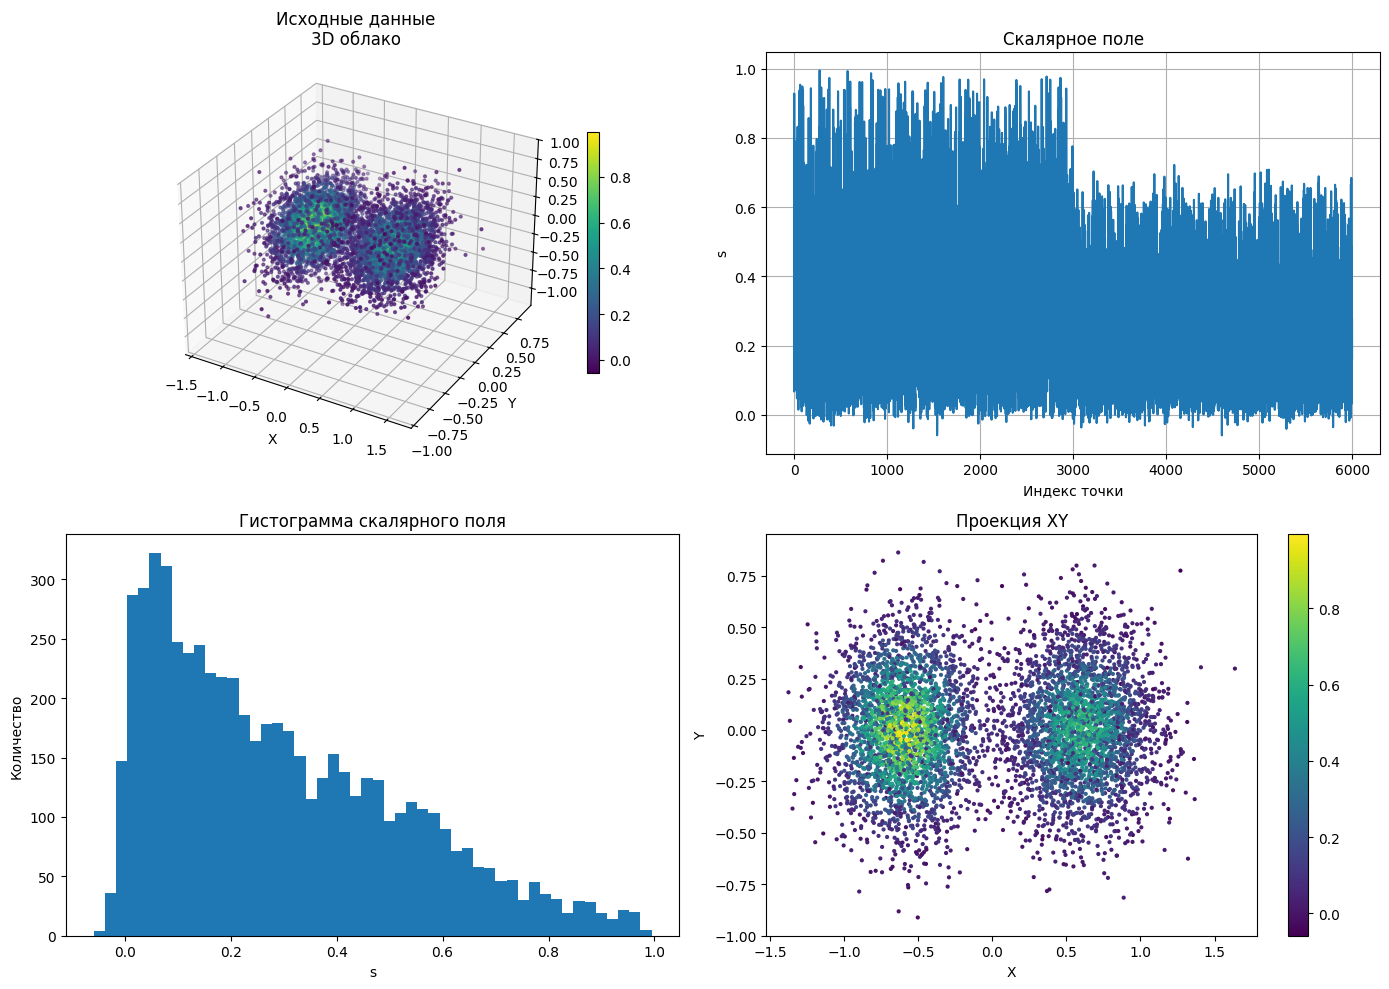

Сохранено: task4_output/points.txt


In [44]:
pts = gen_two_gaussians(n=6000, seed=42)
xyz = pts[:, :3]
s = pts[:, 3]

visualize_scalar_field(pts, title="Исходные данные", cmap=cfg.cmap)
save_txt(out_file, pts, header="x y z s")
print("Сохранено:", out_file)

Задание 1. Умножить скалярное поле на число

In [30]:
def multiply(field: np.ndarray, k: float) -> np.ndarray:
    """Умножение скалярного поля на число."""
    return field.astype(float) * float(k)

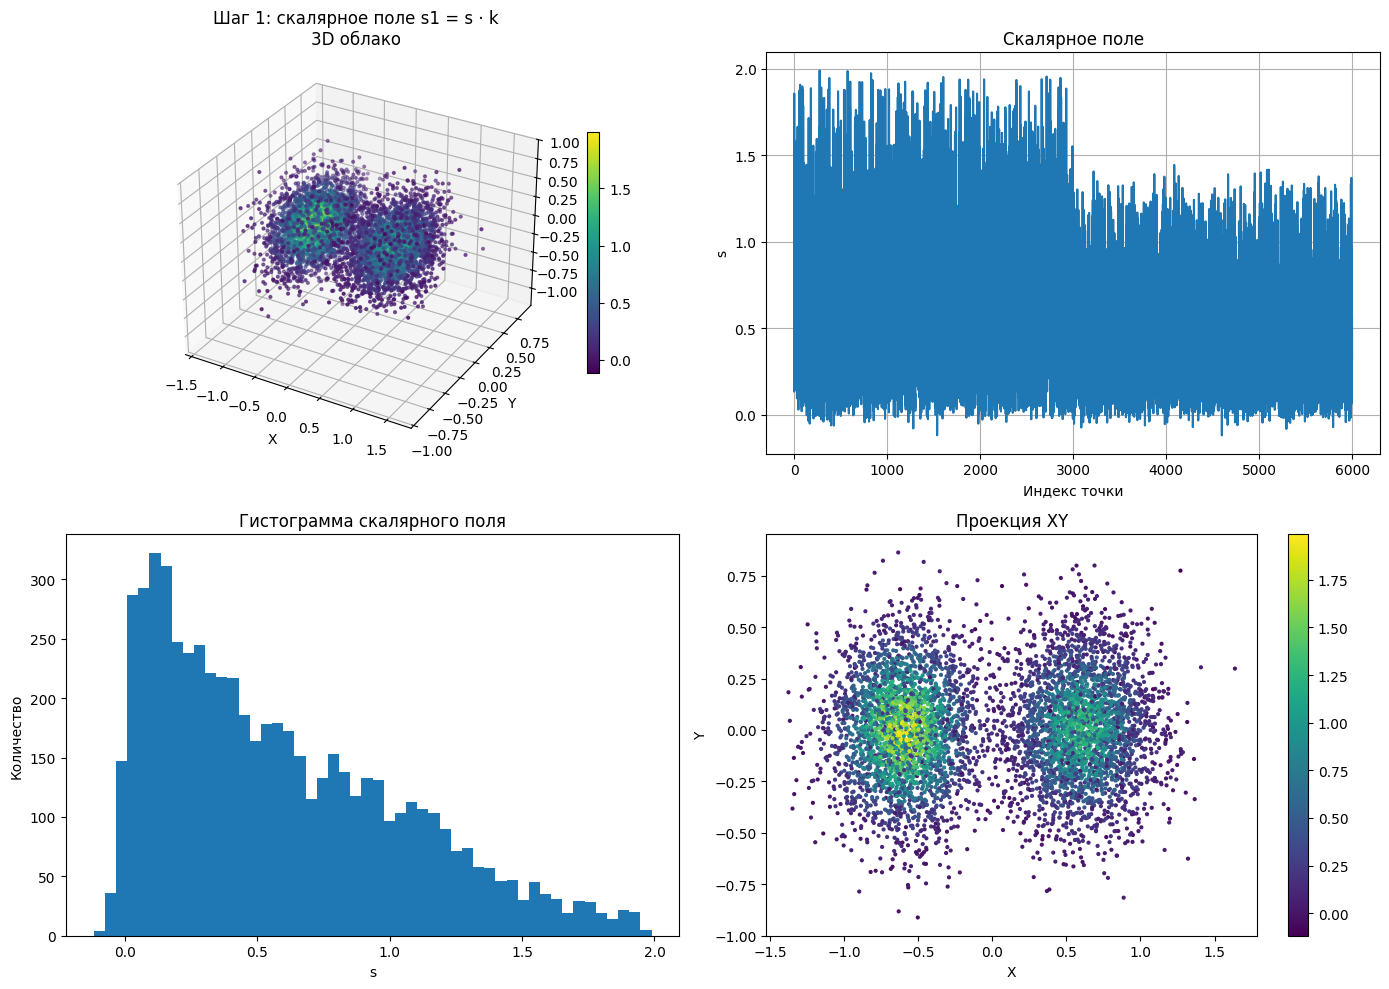

In [48]:
s1 = multiply(np.nan_to_num(s, nan=np.nanmean(s)), cfg.mul_k)
pts_s1 = np.column_stack([xyz, s1])

visualize_scalar_field(
    pts_s1,
    title="Шаг 1: скалярное поле s1 = s · k",
    cmap=cfg.cmap
)
save_txt(os.path.join(cfg.base_dir, "01_mul.txt"), pts_s1, header="x y z s1")

Задание 2. Добавить число к значениям скалярного поля

In [32]:
def add_number(field: np.ndarray, b: float) -> np.ndarray:
    """Добавление константы к скалярному полю."""
    return field.astype(float) + float(b)

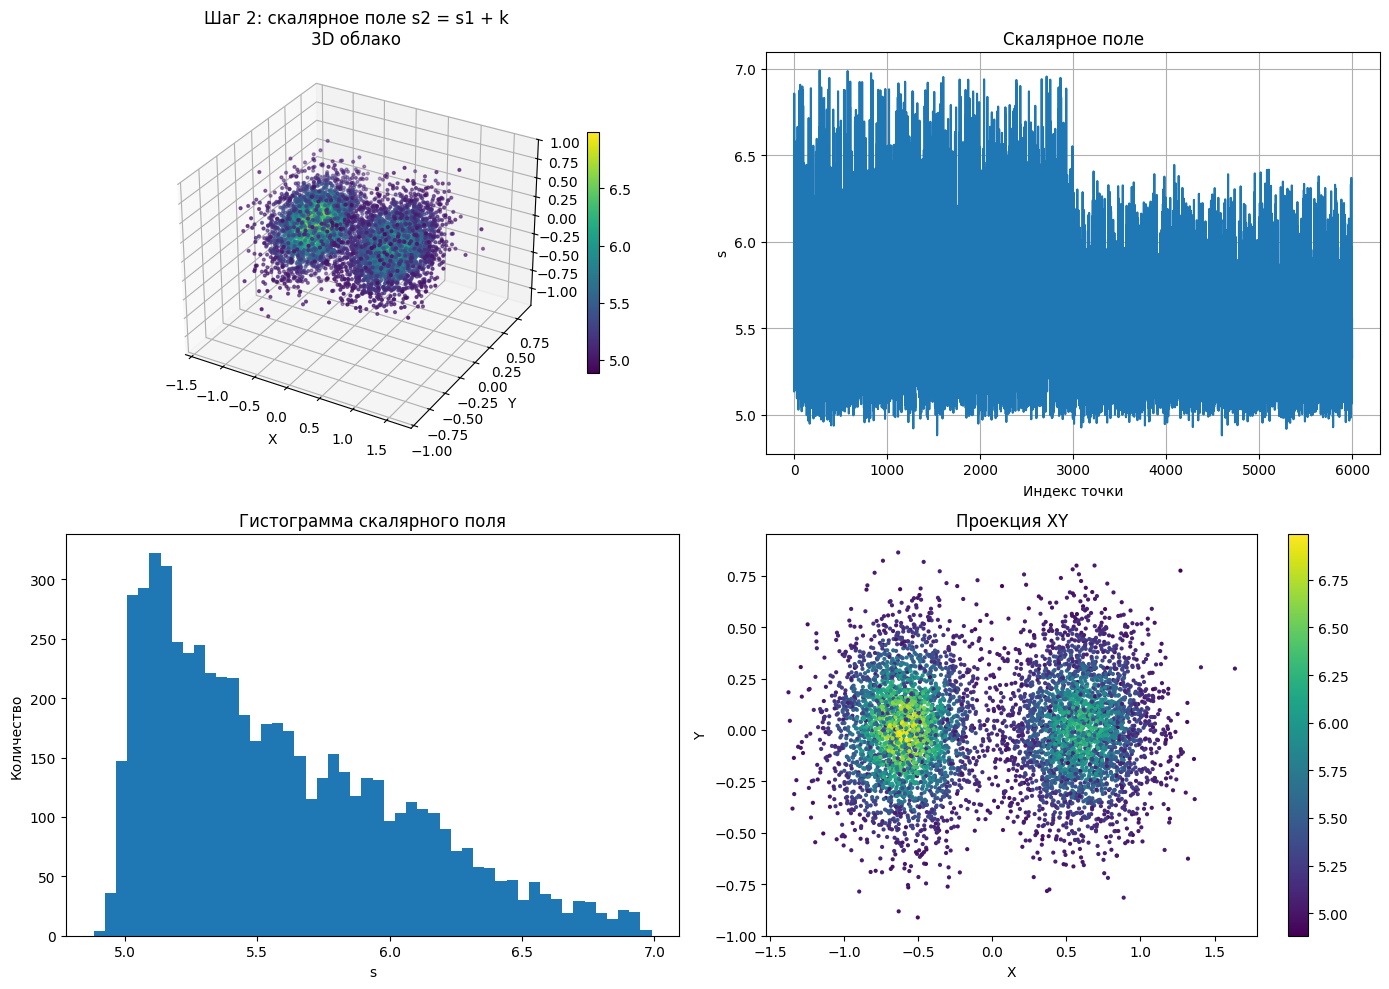

In [70]:
s2 = add_number(s, cfg.add_b)
pts_s2 = np.column_stack([xyz, s2])

visualize_scalar_field(
    pts_s2,
    title="Шаг 2: скалярное поле s2 = s1 + k",
    cmap=cfg.cmap
)
save_txt(os.path.join(cfg.base_dir, "02_add.txt"), pts_s2, header="x y z s2")

Задание 3. Применить гауссов фильтр (сглаживание)

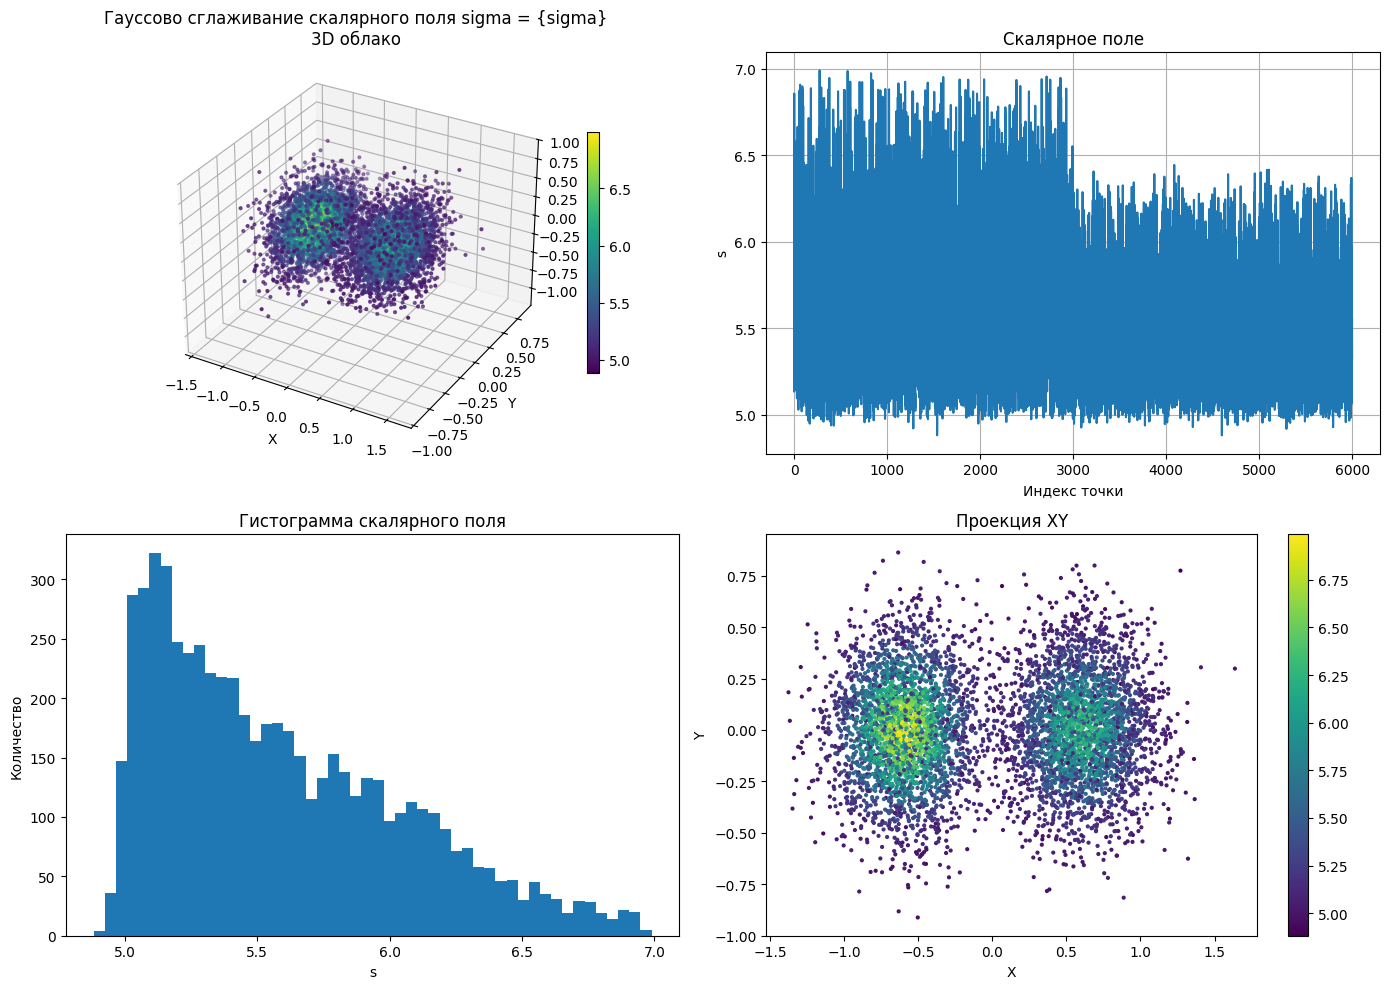

In [61]:
s3 = gaussian_filter1d(s.astype(float),sigma=cfg.gaussian_sigma)
pts_s3 = np.column_stack([xyz, s2])

visualize_scalar_field(
    pts_s3,
    title="Гауссово сглаживание скалярного поля sigma = {sigma}",
    cmap=cfg.cmap
)
save_txt(
    os.path.join(cfg.base_dir, "03_gaussian_sigma.txt"),
    pts_s3,
    header="x y z s_gauss"
)

Задание 4. Вычислить градиент скалярного поля

In [50]:
def gradient(field: np.ndarray) -> np.ndarray:
    """Градиент (по индексу)."""
    return np.gradient(field.astype(float))

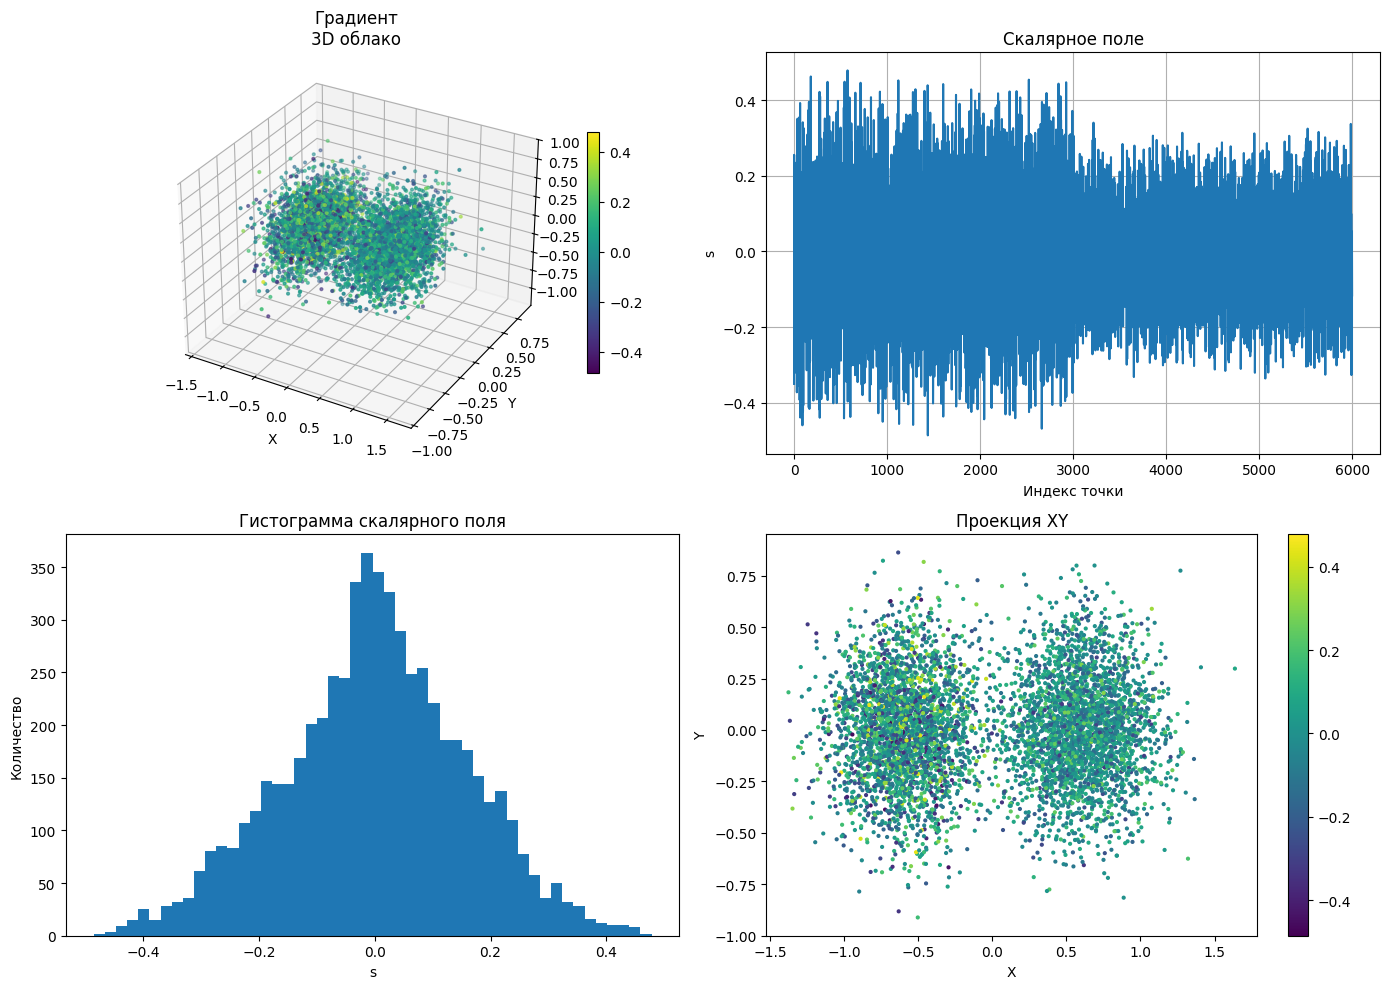

In [71]:
s4 = gradient(s)
pts_s4 = np.column_stack([xyz, s4])

visualize_scalar_field(
    pts_s4,
    title="Градиент",
    cmap=cfg.cmap
)
save_txt(
    os.path.join(cfg.base_dir, "04_gradient.txt"),
    pts_s4,
    header="x y z s_gradient"
)

Задание 5. Повторное сглаживание (например, скользящее
среднее)

In [51]:
def moving_average(field: np.ndarray, window: int) -> np.ndarray:
    """Скользящее среднее."""
    w = int(window)
    kernel = np.ones(w, dtype=float) / w
    return np.convolve(field.astype(float), kernel, mode="same")

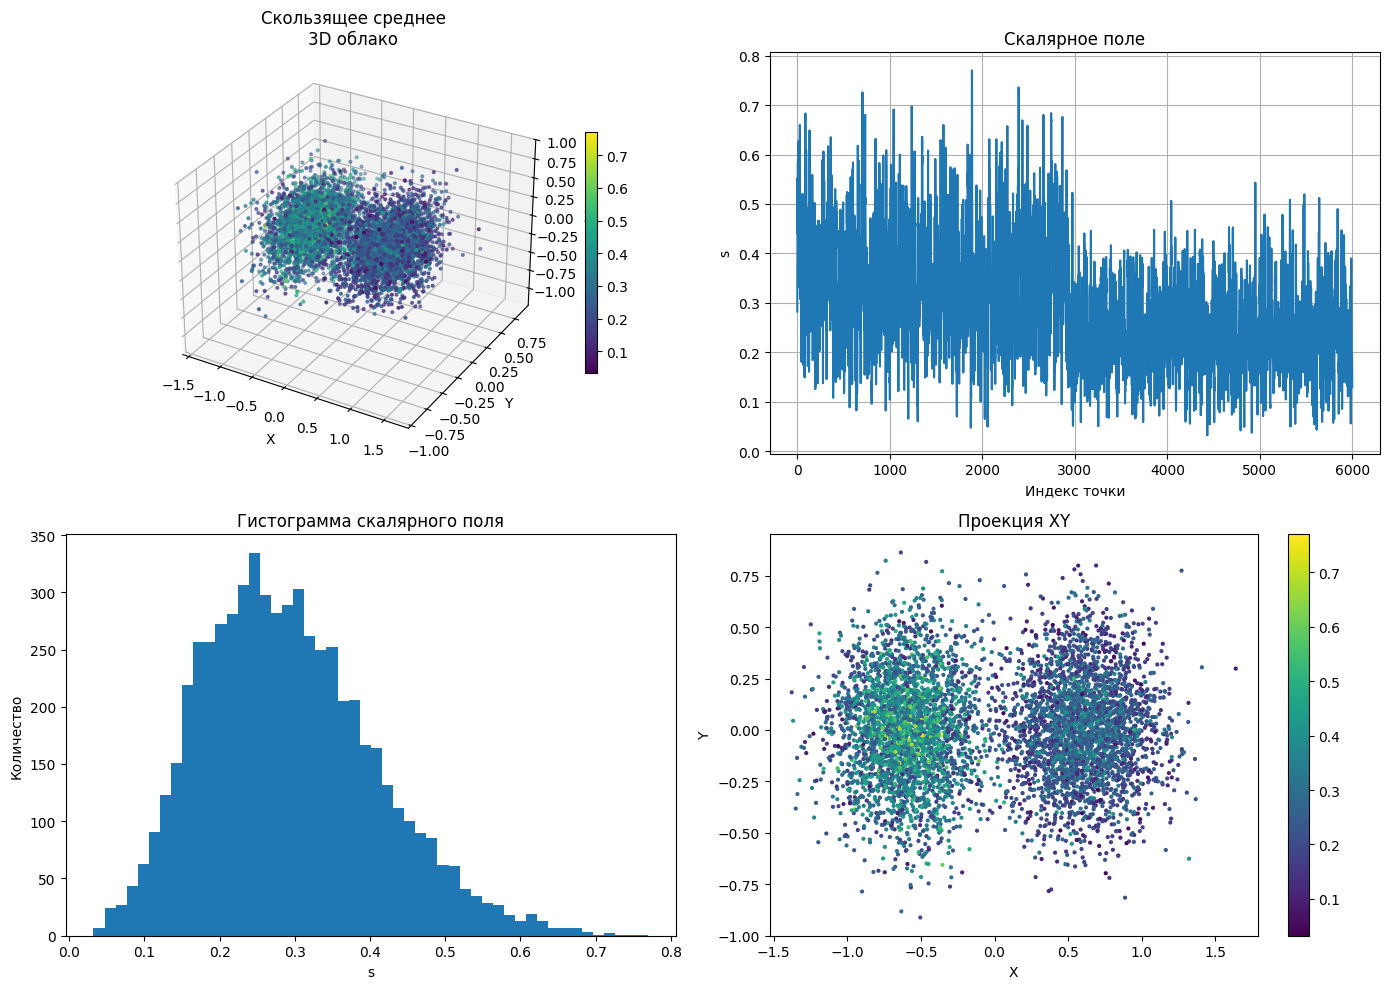

In [72]:
s5 = moving_average(s, cfg.ma_window)
pts_s5 = np.column_stack([xyz, s5])

visualize_scalar_field(
    pts_s5,
    title="Скользящее среднее",
    cmap=cfg.cmap
)
save_txt(
    os.path.join(cfg.base_dir, "05_moving_average.txt"),
    pts_s5,
    header="x y z s_moving_average"
)

Задание 6. Преобразовать скалярное поле в RGB цвета

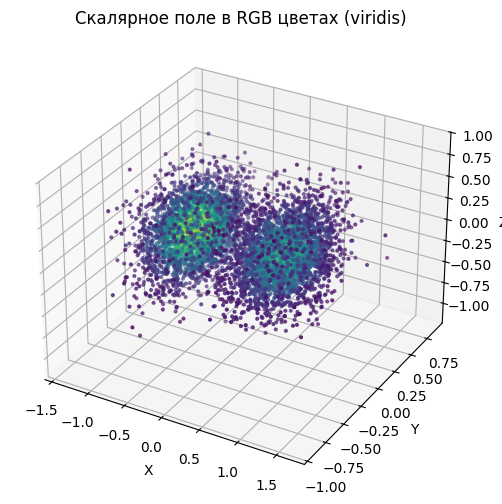

In [69]:
normed = (s - s.min()) / (s.max() - s.min())
colors = plt.cm.viridis(normed)[:, :3]

pts_rgb = np.column_stack([xyz, colors])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    pts_rgb[:, 0],
    pts_rgb[:, 1],
    pts_rgb[:, 2],
    c=pts_rgb[:, 3:6],
    s=4
)

ax.set_title("Скалярное поле в RGB цветах (viridis)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

save_txt(
    os.path.join(cfg.base_dir, "06_xyz_rgb.txt"),
    pts_rgb,
    header="x y z r g b"
)

Задание 7. Вычислить статистические параметры

In [81]:
mean_val = s.mean()
std_val  = s.std()
min_val  = s.min()
max_val  = s.max()

stats_table = pd.DataFrame(
    {
        "Параметр": ["Среднее", "Стандартное отклонение", "Минимум", "Максимум"],
        "Значение": [mean_val, std_val, min_val, max_val],
    }
).set_index("Параметр")

stats_table

,Значение
Параметр,
Среднее,0.292724
Стандартное отклонение,0.231965
Минимум,-0.058926
Максимум,0.994610


Задание 8. Нормализовать значения в диапазон [0, 1]

In [83]:
def normalize_01(field: np.ndarray) -> np.ndarray:
    """Нормализация в [0,1]."""
    f = field.astype(float)
    mn = np.nanmin(f)
    mx = np.nanmax(f)
    denom = (mx - mn) if (mx - mn) != 0 else 1.0
    return (f - mn) / denom

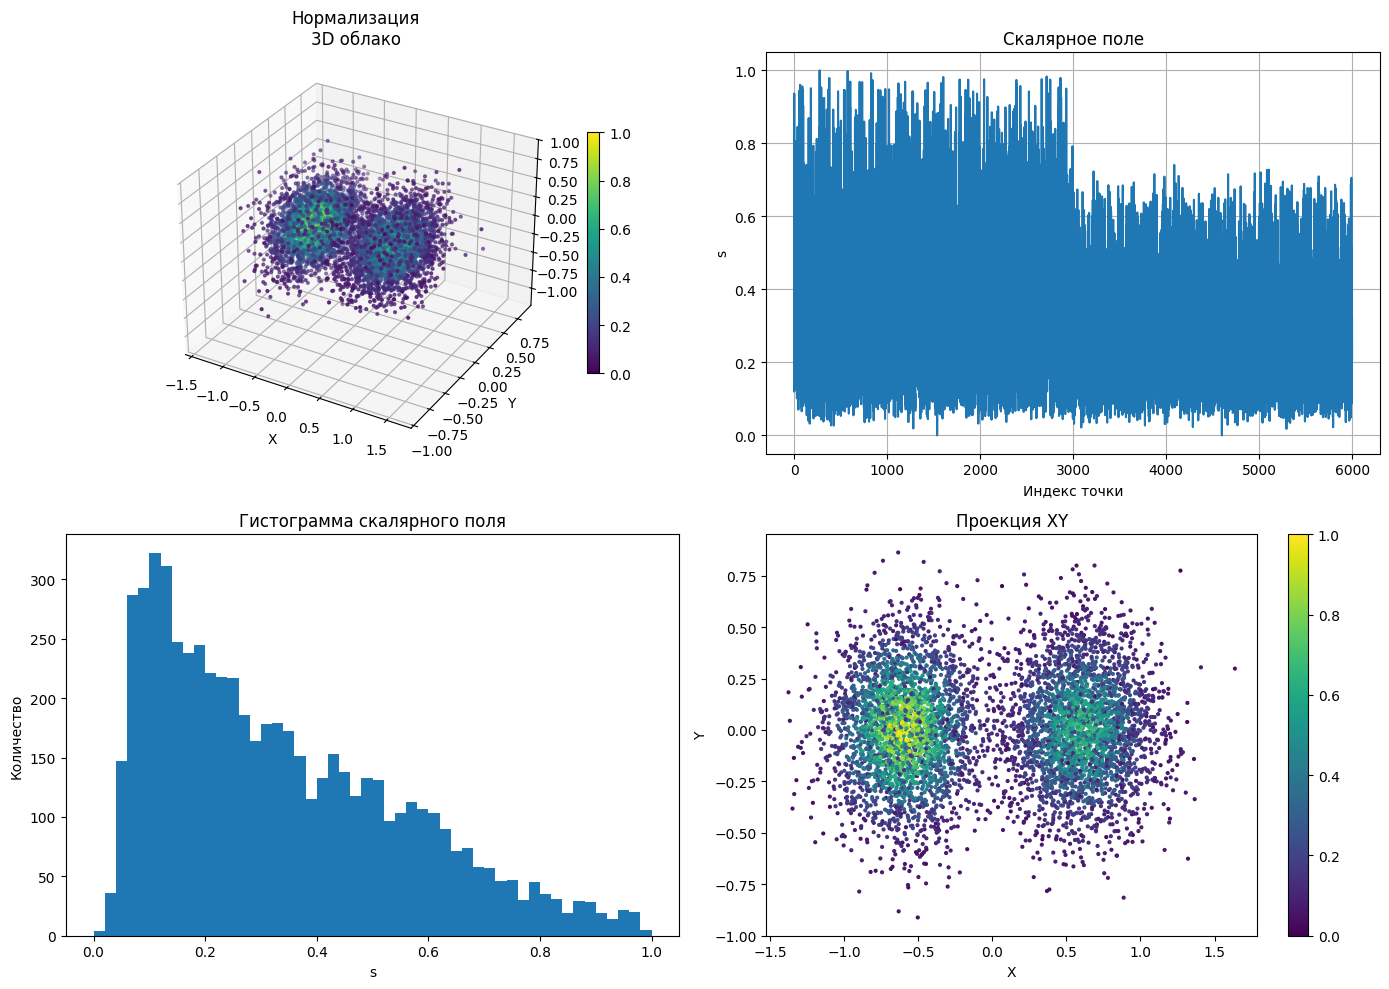

In [84]:
norm = normalize_01(s)
pts_norm = np.column_stack([xyz, norm])

visualize_scalar_field(
    pts_norm,
    title="Нормализация",
    cmap=cfg.cmap
)
save_txt(
    os.path.join(cfg.base_dir, "08_norm.txt"),
    pts_norm,
    header="x y z s_norm"
)

Задание 9. Фильтрация по значению скалярного поля

In [92]:
def filter_by_range(xyz: np.ndarray, s: np.ndarray, lo: float, hi: float) -> np.ndarray:
    """Фильтрация точек по диапазону значений скалярного поля."""
    mask = (s >= lo) & (s <= hi)
    return xyz[mask]

Задание 10. Использовать скалярное поле как координату

In [93]:
def use_field_as_z(xyz: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Заменить Z на значение скалярного поля."""
    out = xyz.copy()
    out[:, 2] = s.astype(float)
    return out